In [6]:
import pandas as pd
import numpy as np

# Load the existing dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')

# Example: Modify sensor values (scaling or adding noise)
data['Sensor Value'] = data['Sensor Value'] * np.random.uniform(0.9, 1.1, size=len(data))

# Example: Add new synthetic data
new_samples = pd.DataFrame({
    'Sensor Value': np.random.uniform(0.1, 2.5, size=500),  # 500 new samples
    'Category': np.random.randint(0, 5, size=500)  # Assign random class (0-4)
})

# Merge datasets
data = pd.concat([data, new_samples], ignore_index=True)

# Save updated dataset
data.to_csv('updated_piezoelectric_breathing_dataset.csv', index=False)

print("Dataset updated and saved as 'updated_piezoelectric_breathing_dataset.csv'.")


Dataset updated and saved as 'updated_piezoelectric_breathing_dataset.csv'.


In [7]:
import numpy as np
import pandas as pd

np.random.seed(42)  # For reproducibility

num_samples = 3000  # New dataset size

# Generate random sensor values
sensor_values = np.random.uniform(0.1, 2.5, size=num_samples)

# Define categories based on sensor values
categories = np.digitize(sensor_values, bins=[1.0, 1.5, 2.0, 2.5], right=True)

# Map categories to class labels
categories = np.where(categories == 4, 4, categories)  # Ensure 5 classes (0-4)

# Create a DataFrame
new_data = pd.DataFrame({'Sensor Value': sensor_values, 'Category': categories})

# Save the new dataset
new_data.to_csv('new_piezoelectric_breathing_dataset.csv', index=False)

print("New dataset created and saved as 'new_piezoelectric_breathing_dataset.csv'.")


New dataset created and saved as 'new_piezoelectric_breathing_dataset.csv'.


In [8]:
# Load new dataset
data = pd.read_csv('new_piezoelectric_breathing_dataset.csv')

# Extract values
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Convert sensor values into images
X = np.array([np.full((32, 32, 3), value / 2.5) for value in sensor_values])  # Normalize

# Convert labels
y = np.array(categories)

# Split into train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("New dataset loaded and preprocessed successfully!")


New dataset loaded and preprocessed successfully!


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3314 - loss: 1.6921 - val_accuracy: 0.5850 - val_loss: 0.9125
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6109 - loss: 0.8484 - val_accuracy: 0.9033 - val_loss: 0.3429
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8147 - loss: 0.4477 - val_accuracy: 0.8733 - val_loss: 0.3171
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8798 - loss: 0.2999 - val_accuracy: 0.9100 - val_loss: 0.1853
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9112 - loss: 0.2611 - val_accuracy: 0.9717 - val_loss: 0.0743
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9452 - loss: 0.1584 - val_accuracy: 0.9083 - val_loss: 0.2139
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9296 - loss: 0.1879 - val_accuracy: 0.8667 - val_loss: 0.3319
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9233 - loss: 0.2022 - val_accuracy: 0.9800 - val_loss:

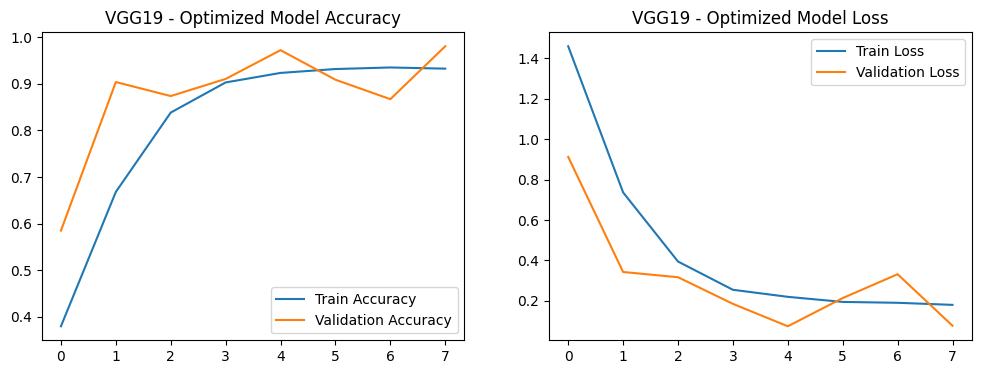

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.image import resize

# Step 1: Resize input dataset to match VGG19 input shape (32x32x3)
X_train = np.array([resize(img, (32, 32)).numpy() for img in X_train])
X_test = np.array([resize(img, (32, 32)).numpy() for img in X_test])

X_train = X_train.astype('float32')  # Ensure correct data type
X_test = X_test.astype('float32')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Step 2: Load VGG19 with optimized settings
base_model = VGG19(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

# Freeze all layers except last 5 for fine-tuning
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Define model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # More efficient than Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes: Normal, Shallow, Deep, Apnea, Irregular
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,  # Reduced from 30 to 15
    batch_size=64,  # Increased batch size for faster training
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('piezoelectric_breathing_model_vgg19_optimized.h5')

# Step 4: Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG19 - Optimized Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG19 - Optimized Model Loss')
plt.legend()

plt.show()


In [10]:
import tensorflow as tf
import numpy as np

# Step 1: Load the trained VGG19 model
model = tf.keras.models.load_model('piezoelectric_breathing_model_vgg19_optimized.h5')

# Function to predict breathing pattern using VGG19
def predict_breathing_pattern(sensor_value):
    # Normalize the input sensor value
    sensor_normalized = sensor_value / 2.5  # Normalize based on dataset range

    # Generate a synthetic image of shape (32, 32, 1)
    X_input = np.full((32, 32, 1), sensor_normalized)

    # Convert grayscale to RGB (VGG19 expects 3 channels)
    X_input_rgb = np.repeat(X_input, 3, axis=-1)

    # Add batch dimension
    X_input_rgb = np.expand_dims(X_input_rgb, axis=0)

    # Predict using the VGG19 model
    predictions = model.predict(X_input_rgb)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Map predicted class index to label
    class_labels = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular']
    predicted_label = class_labels[predicted_class]

    return predicted_label, predictions

# Input sensor value from user
sensor_value = float(input("Enter a piezoelectric sensor value: "))
predicted_label, probabilities = predict_breathing_pattern(sensor_value)

# Output the result
print(f"Sensor Value: {sensor_value} -> Predicted: {predicted_label}")
print(f"Class Probabilities: {probabilities}")


Enter a piezoelectric sensor value:  503


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Sensor Value: 503.0 -> Predicted: Apnea
Class Probabilities: [[0. 0. 0. 1. 0.]]


In [11]:
import tensorflow as tf

# Load the trained VGG19 model
model = tf.keras.models.load_model('piezoelectric_breathing_model_vgg19_optimized.h5')


In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2  # For resizing images

# Load the dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Generate synthetic images with required input shape (32x32x3 for VGG19)
X = np.array([np.full((128, 128, 1), value / 2.5) for value in sensor_values])  # Normalize
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

# Resize images to 32x32 for VGG19
X_resized = np.array([cv2.resize(img, (32, 32)) for img in X])

y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

print("Dataset preprocessed and resized for VGG19.")


Dataset preprocessed and resized for VGG19.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# Generate predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Define class labels (ensure they match the dataset)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular']

# Print evaluation metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nVGG19 - Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
Confusion Matrix:
[[  0  79   1   0   0]
 [133   2   0   0   0]
 [  0   0  81   0   0]
 [  0   0   7  82   0]
 [  6   7   0   2   0]]

VGG19 - Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        80
     Shallow       0.02      0.01      0.02       135
        Deep       0.91      1.00      0.95        81
       Apnea       0.98      0.92      0.95        89
   Irregular       0.00      0.00      0.00        15

    accuracy                           0.41       400
   macro avg       0.38      0.39      0.38       400
weighted avg       0.41      0.41      0.41       400

Precision: 0.4092
Recall: 0.4125
F1 Score: 0.4099


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

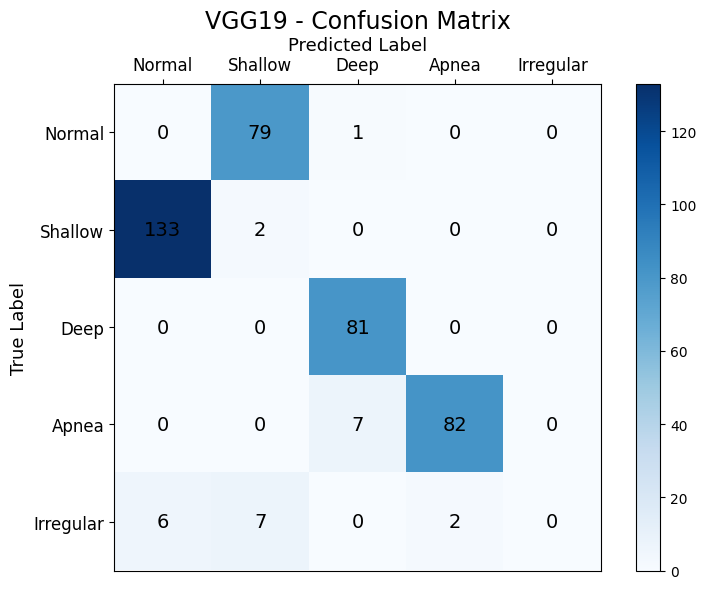

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class labels dynamically based on unique classes in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')  # Use the 'Blues' colormap
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set axis labels and ticks
ticks = range(len(target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(target_names, fontsize=12)
ax.set_yticklabels(target_names, fontsize=12)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Set axis labels and title
ax.set_xlabel('Predicted Label', fontsize=13)
ax.set_ylabel('True Label', fontsize=13)
plt.title('VGG19 - Confusion Matrix', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()
